In [25]:
%load_ext autoreload
%autoreload 2





The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
test = np.array([[0.,1.],[1.,0.]])
test[0] = test[0]*2-0.5
print(test[0])
np.sum(test, axis = 0)

[-0.5  1.5]


array([0.5, 1.5])

In [4]:
import numpy as np
import pandas as pd
import numpy.linalg 
from tqdm import tqdm
import numba
from numba import njit,vectorize, jit
import time
import scipy
import matplotlib.pyplot as plt

import Estimators
import Unsupervised
import Kernels as K 

In [27]:
sig2 = 1
d = 1.1
c = 0

In [28]:
def importation(): 
    X_train = []
    X_test = []
    Y_train = []
    Y_train_Rademacher = []
    for i in range(3): 
        xtrain = pd.read_csv('data/Xtr'+str(i)+'.csv',delimiter= ',', header= None)
        xtrain = xtrain.iloc[1:,1].to_numpy()
        X_train.append(xtrain)
    
        xtest = pd.read_csv('data/Xte'+str(i)+'.csv',delimiter= ',', header= None)
        xtest = xtest.iloc[1:,1]
        X_test.append(xtest)
        
        ytrain = pd.read_csv('data/Ytr'+str(i)+'.csv',delimiter= ',')['Bound'].to_numpy()
        Y_train.append(ytrain)
        
        Y_train_Rademacher = 2*ytrain-1
    return X_train,X_test,Y_train, Y_train_Rademacher

X_train,X_test,Y_train, Y_train_Rademacher = importation()

## Quelques fonctions que je mettrai dans un module plus tard

In [50]:
@njit
def PolynomialKernel(x,y): 
    return (x.dot(y)+c)**d

@njit
def GaussianKernel(x,y,sig2 = 1):
    return np.exp(-numpy.linalg.norm(x-y)**2/(2*sig2))

@njit
def LinearKernel(x,y): 
    return x.dot(y)

In [30]:
@njit
def to_Kernel_train(X, Kernel, sig2 = 1): 
    length = X.shape[0]
    mat_K = np.zeros((length,length))
    for i in range(length):
        x_i = X[i,:]
        for j in range(i,length): 
            x_j = X[j,:]
            value = Kernel(x_i,x_j)
            mat_K[i,j] = value
            mat_K[j,i] = value 
    return mat_K

@njit 
def to_Kernel_test(Xtrain,Xtest,Kernel,sig2=1):
    length_train = Xtrain.shape[0]
    length_test = Xtest.shape[0]
    bimat_K = np.zeros((length_train,length_test))
    for i in range(length_train):
        x_i = Xtrain[i,:]
        for j in range(length_test): 
            x_j = Xtest[j,:]
            value = Kernel(x_i,x_j)
            bimat_K[i,j] = value
    return bimat_K


def standardize(K): 
    U = np.full(K.shape,1/K.shape[0])
    I = np.eye(K.shape[0])
    return (I-U)@K@(I-U)

## Module Estimator

In [31]:
Estimators.estimator(GaussianKernel)

In [32]:

for i in range(1) : 
    KRR_estim = Estimators.KRR( Kernel = GaussianKernel, lam = 10**(-13))
    KRR_estim.cross_val(X_train[0],Y_train[0],cv=10)

AxisError: axis 1 is out of bounds for array of dimension 1

## Module Unsupervised

In [33]:
def create_z(mu_init, nb_samples): 
    '''
    small function to create  GMM. The only purpose of it is to test our KernelKmeans and Kmeans
    '''
    
    K = len(mu_init)
    z = mu_init[0]+ np.random.randn(nb_samples,2)
    true_clusters = np.zeros(nb_samples)
    for i in range(1,K): 
        z = np.concatenate((mu_init[i]+ np.random.randn(nb_samples,2),z),axis = 0)
        true_clusters = np.concatenate((true_clusters,np.full(nb_samples,i)))

    return z,true_clusters 

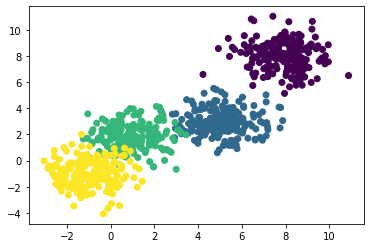

In [34]:
nb_samples = 200
mu_init_z = np.array([[-1,-1],[1,2],[5,3],[8,8]])
nb_clusters = len(mu_init_z)
z,true_clusters = create_z(mu_init_z,nb_samples)
plt.scatter(z[:,0],z[:,1], c = true_clusters)

In [35]:
mat_gaussian = to_Kernel_train(z,GaussianKernel)
mat_linear = to_Kernel_train(z,LinearKernel)
mat_poly = to_Kernel_train(z,PolynomialKernel)

Initilisation : 


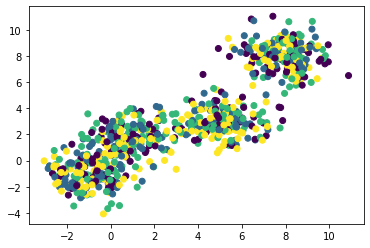

Update : 


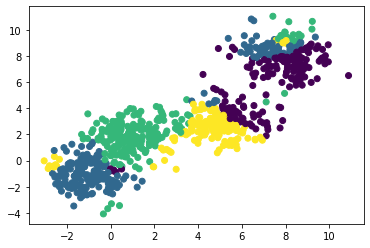

Update : 


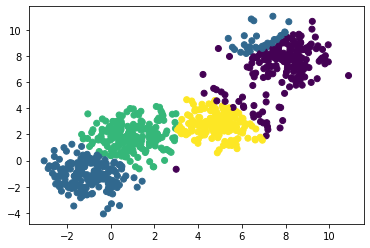

Update : 


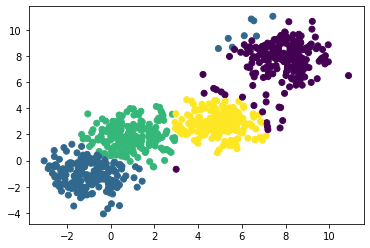

Update : 


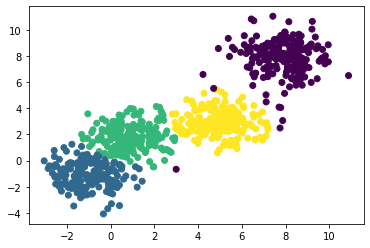

Update : 


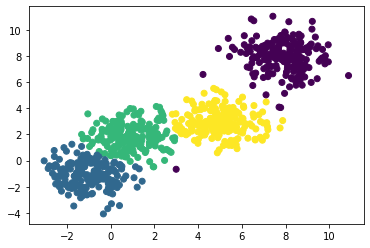

CPU times: user 52.6 s, sys: 1.51 s, total: 54.1 s
Wall time: 52 s


In [38]:
KKM = Unsupervised.KernelKmeans()
%time KKM.fit(mat_gaussian,4,Niter_max=5, z=z)

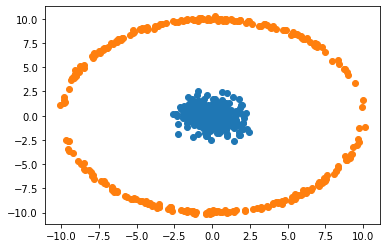

In [39]:
r=100
nb_points = 300
center = np.random.randn(nb_points,2)
outside_x = (2*np.random.randint(2,size= nb_points)-1)*np.sqrt(r)*np.random.rand(nb_points)
outside_y = (2*np.random.randint(2,size= nb_points)-1)*np.sqrt(r-outside_x**2)
outside_x += 0.1*np.random.randn(nb_points)
outside_y += 0.1*np.random.randn(nb_points)
plt.scatter(center[:,0],center[:,1])
plt.scatter(outside_x,outside_y)

In [40]:
outside = np.column_stack((outside_x,outside_y))
z_rond = np.concatenate((center,outside))

In [41]:
mat_gaussian_z_rond = to_Kernel_train(z_rond,GaussianKernel)
mat_line_z_rond = to_Kernel_train()

Initilisation : 


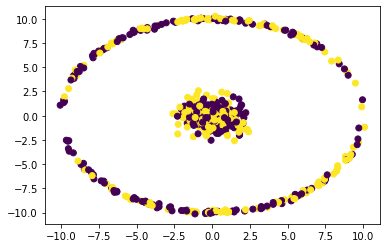

Update : 


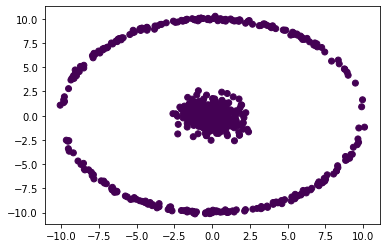

Update : 


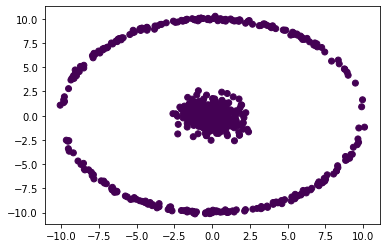

Update : 


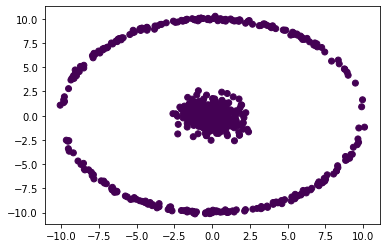

In [53]:
d = 1.1
c = 0
sig2 =1
mat_poly_z_rond = to_Kernel_train(z_rond,PolynomialKernel)

KKM.fit(mat_poly_z_rond,2,Niter_max=3, z=z_rond,viz = True)